# 深度神经网络作业

## 实验过程

### 准备阶段
首先导入必要的库

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

加载数据集，并且定义训练和测试图像变换操作

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

extract_path = './dataset/101_ObjectCategories'

dataset = datasets.ImageFolder(root=extract_path, transform=train_transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### 定义模型

使用经典的 VGG16 模型，并初始化权重

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

定义训练函数和测试函数，并画图

In [ ]:
def train_model(num_epochs, model, criterion, optimizer, scheduler, train_loader, device):
    model.train()
    train_losses = [] 
    train_accuracies = []

    for epoch in range(num_epochs):
        print(f'training on epoch:{epoch}')
        running_loss = 0.0
        total = 0
        correct = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        scheduler.step()
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%')
        train_losses.append(epoch_loss) 
        train_accuracies.append(epoch_accuracy) 

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def evaluate_model(model, test_loader, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_accuracy = 100 * correct / total
        print(f'Test Loss: {epoch_loss:.4f}, Test Accuracy: {epoch_accuracy:.2f}%')

### 开始训练

主函数如下

training on epoch:0


100%|██████████| 229/229 [08:54<00:00,  2.33s/it]


Epoch [1/10], Loss: 5.4843, Train Accuracy: 6.92%
training on epoch:1


100%|██████████| 229/229 [08:57<00:00,  2.35s/it]


Epoch [2/10], Loss: 4.3345, Train Accuracy: 9.19%
training on epoch:2


100%|██████████| 229/229 [10:22<00:00,  2.72s/it]


Epoch [3/10], Loss: 3.6741, Train Accuracy: 24.46%
training on epoch:3


100%|██████████| 229/229 [10:18<00:00,  2.70s/it]


Epoch [4/10], Loss: 3.1275, Train Accuracy: 32.37%
training on epoch:4


100%|██████████| 229/229 [09:50<00:00,  2.58s/it]


Epoch [5/10], Loss: 2.6135, Train Accuracy: 40.33%
training on epoch:5


100%|██████████| 229/229 [10:12<00:00,  2.67s/it]


Epoch [6/10], Loss: 2.1728, Train Accuracy: 48.24%
training on epoch:6


100%|██████████| 229/229 [10:29<00:00,  2.75s/it]


Epoch [7/10], Loss: 1.7173, Train Accuracy: 57.06%
training on epoch:7


100%|██████████| 229/229 [10:18<00:00,  2.70s/it]


Epoch [8/10], Loss: 1.2909, Train Accuracy: 66.48%
training on epoch:8


100%|██████████| 229/229 [07:16<00:00,  1.90s/it]


Epoch [9/10], Loss: 0.8665, Train Accuracy: 77.22%
training on epoch:9


100%|██████████| 229/229 [02:35<00:00,  1.47it/s]


Epoch [10/10], Loss: 0.5809, Train Accuracy: 84.20%


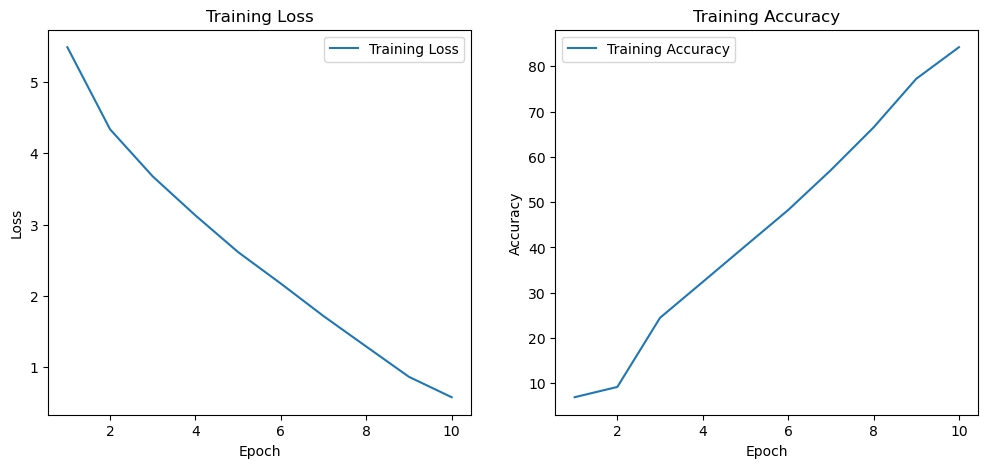

100%|██████████| 58/58 [00:18<00:00,  3.10it/s]

Test Loss: 2.0765, Test Accuracy: 57.57%


In [ ]:
model = VGG16()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
train_model(epochs, model, criterion, optimizer, scheduler, train_loader, device)
evaluate_model(model, test_loader, device)
